###### hw3_109064518
###### import所需要的套件

In [1]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

In [3]:
def to_categorical(y, num_classes=None, dtype='float32'):##label onehot function
    y = np.array(y, dtype='int')
    input_shape = y.shape
    if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
        input_shape = tuple(input_shape[:-1])
    y = y.ravel()
    if not num_classes:
        num_classes = np.max(y) + 1
    n = y.shape[0]
    categorical = np.zeros((n, num_classes), dtype=dtype)
    categorical[np.arange(n), y] = 1
    output_shape = input_shape + (num_classes,)
    categorical = np.reshape(categorical, output_shape)
    return categorical

######Load mnist-training data and test data(in colab,資料從雲端硬碟抓取)





In [4]:
from pylab import imread,imshow,show,subplot 
Carambula_img_list=[]
Lychee_img_list=[]
Pear_img_list=[]
data_dir =r'/content/drive/My Drive/Colab Notebooks/Fruit/Data_train'
for root, dirs, files in os.walk(data_dir):#os.walk會把該函數得到之位置底下所有資料夾都打開找過一次
    for file in files:
        if file.endswith(".png"):
            filename = os.path.join(root, file)
            category_name = os.path.basename(root)#os.path.basename這個函數來把最後一層資料夾的名稱取出來
            im = imread(filename)
            imarray = np.array(im)
            imarray = (imarray - np.min(imarray))/(np.max(imarray)-np.min(imarray))
            if category_name == 'Carambula':
                Carambula_img_list.append(imarray)
            elif category_name == 'Lychee':
                Lychee_img_list.append(imarray)
            elif category_name == 'Pear':
                Pear_img_list.append(imarray)

#透過np.asarray把list整理成array  
Carambula_img_arr = np.asarray(Carambula_img_list)
Lychee_img_arr = np.asarray(Lychee_img_list)
Pear_img_arr = np.asarray(Pear_img_list)
#手動製作Label標籤  
Carambula_img_label = np.ones(Carambula_img_arr.shape[0])*0
Lychee_img_label = np.ones(Lychee_img_arr.shape[0])*1
Pear_img_label = np.ones(Pear_img_arr.shape[0])*2

img_arr   = np.concatenate((Carambula_img_arr, Lychee_img_arr,Pear_img_arr), axis = 0)  #合併三個種類的圖片
img_label = np.concatenate((Carambula_img_label, Lychee_img_label,Pear_img_label), axis = 0) #合併三個種類的Label
img_label = to_categorical(img_label, num_classes = 3)  #將Label進行one hot轉換

print(img_arr.shape)
print(img_label)
print(img_label.shape)

(1470, 32, 32, 4)
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]
(1470, 3)


######將label和image進行隨機排序

In [5]:
import random
temp = list(zip(img_arr, img_label))
random.shuffle(temp)
img_arr, img_label = zip(*temp)
img_arr=np.asarray(img_arr)
img_label=np.asarray(img_label)


#####分割image和label的函式(共1470筆) train:validation=7:3





In [6]:
def shuffle_split_data(X_image,label,flatten=False):#分割image和label的函式 train:validation=7:3

    
    #noramalize x
    
    
    

    # we reserve the last 18000 training examples for validation
    X_train, X_validation = X_image[:-441], X_image[-441:] 
    y_train, y_validation = label[:-441], label[-441:]

     

    print("Image:")
    print(len(X_train),len(X_validation))
    print("label:")
    print(len(y_train),len(y_validation))
    return X_train,X_validation,y_train,y_validation

In [7]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy
import sys
# image_resize=np.reshape(img_arr,(1470,-1))
# label_resize=np.reshape(img_label,(1470,-1))
image_train,image_validation,label_train,label_validation,=shuffle_split_data(img_arr,img_label,flatten=True)
print(image_train.shape)

new_image1=image_train.reshape(1029, 4, 32, 32)
new_valimage1=image_validation.reshape(441, 4, 32, 32)
print(type(image_train))

Image:
1029 441
label:
1029 441
(1029, 32, 32, 4)
<class 'numpy.ndarray'>


In [8]:
%cd /content/drive/My Drive/Colab Notebooks/Fruit/src
from utils import *
from layers import *
from model import LeNet5
import numpy as np
import pickle
import matplotlib.pyplot as plt
from tqdm import trange
from timeit import default_timer as timer

/content/drive/My Drive/Colab Notebooks/Fruit/src


######Train function

In [9]:
from IPython.display import clear_output
import time
import math
import matplotlib
import pylab
import matplotlib.pyplot as plt

In [10]:
train_log = []
val_log = []
train_loss_log=[]
val_loss_log=[]
test_log=[]
test_loss_log=[]


info_train = "train-loss: {:0.6f} | train-acc: {:0.3f}"   
info_val =  "val-loss: {:0.6f} | val-acc: {:0.3f}" 

In [11]:
def train():
  model = LeNet5()
  cost = CrossEntropyLoss()
  lr = 0.0005

  optimizer = AdamGD(lr = lr, beta1 = 0.9, beta2 = 0.999, epsilon = 1e-8, params = model.get_params())    
  train_costs, val_costs = [], []
  # image_train1 = resize_dataset(image_train)
  # image_validation1 = resize_dataset(image_validation)
  print("----------------TRAINING-----------------\n")

  NB_EPOCH = 25
  BATCH_SIZE = 32

  # print("EPOCHS: {}".format(NB_EPOCH))
  # print("BATCH_SIZE: {}".format(BATCH_SIZE))
  # print("LR: {}".format(lr))
  # print()

  nb_train_examples = len(new_image1)
  nb_val_examples = len(new_valimage1)

  best_val_loss = float('inf')

  for epoch in range(NB_EPOCH):
          val_loss = 0
          val_acc = 0 
          train_loss = 0
          train_acc = 0 

             #TRAINING PART
    #
    #-------------------------------------------------------------------------------
          
         

          pbar = trange(nb_train_examples // BATCH_SIZE)
          train_loader = dataloader(new_image1, label_train, BATCH_SIZE)

          start = timer()
          for i, (X_batch, y_batch) in zip(pbar, train_loader):
              
              y_pred = model.forward(X_batch)
              loss = cost.get(y_pred, y_batch)

              grads = model.backward(y_pred, y_batch)
              params = optimizer.update_params(grads)
              model.set_params(params)

              train_loss += loss * BATCH_SIZE
              train_acc += sum((np.argmax(y_batch, axis=1) == np.argmax(y_pred, axis=1)))

              # pbar.set_description("[Train] Epoch {}".format(epoch+1))
          
          end = timer()
                  
     #                               VALIDATION PART
        #
        #-------------------------------------------------------------------------------



          pbar = trange(nb_val_examples // BATCH_SIZE)
          val_loader = dataloader(new_valimage1, label_validation, BATCH_SIZE)

          for i, (X_batch, y_batch) in zip(pbar, val_loader):
              
              y_pred = model.forward(X_batch)
              loss = cost.get(y_pred, y_batch)
              
              grads = model.backward(y_pred, y_batch)
              params = optimizer.update_params(grads)
              model.set_params(params)

              val_loss += loss * BATCH_SIZE
              val_acc += sum((np.argmax(y_batch, axis=1) == np.argmax(y_pred, axis=1)))

              # pbar.set_description("[Val] Epoch {}".format(epoch+1))



          
          train_loss /= nb_train_examples
          train_costs.append(np.mean(train_loss))
          train_acc /= nb_train_examples
          train_log.append(np.mean(train_acc))
          train_loss_log.append(np.mean(train_loss))

         

          val_loss /= nb_val_examples
          val_costs.append(np.mean(val_loss))
          val_acc /= nb_val_examples
          val_log.append(np.mean(val_acc))
          val_loss_log.append(np.mean(val_loss))
          pbar.close()
          clear_output()
          
          # print(info_val.format(val_loss, val_acc))
          #plot training accuracy and validation accuracy  
          fig = plt.figure(figsize=(10,10))
          fig.add_subplot(2, 1, 2)
          print("epoch",epoch)
          print("Train accuracy:",train_log[-1])
          print("Val accuracy:",val_log[-1])
          plt.plot(train_log,label='train accuracy')
          plt.plot(val_log,label='val accuracy')
          plt.legend(loc='best')
          plt.title("Training and Validation accuracy")
          plt.xlabel("epoch")
          plt.ylabel("accuracy")
          plt.grid()
          plt.show()
          if best_val_loss > val_loss:
              print("Validation loss decreased from {:0.6f} to {:0.6f}. Model saved".format(best_val_loss, val_loss))
              save_params_to_file(model)
              best_val_loss = val_loss

          # print()
          # print(info_train.format(train_loss, train_acc))
          # print()
          print(f"Elapsed time for epoch {epoch+1}: {(end-start)/60} min.", end="\n")
          #plot training loss and validation loss  
          fig = plt.figure(figsize=(10,10))
          fig.add_subplot(2, 1, 1)
          print("Epoch",epoch)
          print("Train Loss:",train_loss_log[-1])
          print("Validation Loss:",val_loss_log[-1])
          plt.plot(train_loss_log,label='train loss')
          plt.plot(val_loss_log,label='val loss')
          plt.legend(loc='best')
          plt.title("Training and Validation loss")
          plt.xlabel("Epoch")
          plt.ylabel("Loss")
          plt.grid()
          plt.show()
      
 


epoch 24
Train accuracy: 0.9951409135082604
Val accuracy: 0.9433106575963719


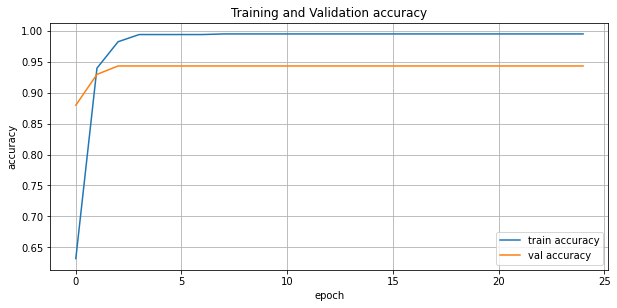

Validation loss decreased from 0.014564 to 0.013596. Model saved
Elapsed time for epoch 25: 0.26004229528333556 min.
Epoch 24
Train Loss: 0.015619788127490528
Validation Loss: 0.013595759036978088


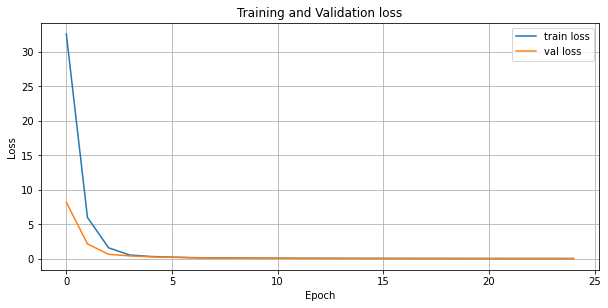

In [12]:
train()

######讀取Test檔

In [13]:
from pylab import imread,imshow,show,subplot 
Carambula_img_list1=[]
Lychee_img_list1=[]
Pear_img_list1=[]
data_dir =r'/content/drive/My Drive/Colab Notebooks/Fruit/Data_test'
for root, dirs, files in os.walk(data_dir):#os.walk會把該函數得到之位置底下所有資料夾都打開找過一次
    for file in files:
        if file.endswith(".png"):
            filename = os.path.join(root, file)
            category_name = os.path.basename(root)#os.path.basename這個函數來把最後一層資料夾的名稱取出來
            im = imread(filename)
            imarray = np.array(im)
            imarray = (imarray - np.min(imarray))/(np.max(imarray)-np.min(imarray))
            if category_name == 'Carambula':
                Carambula_img_list1.append(imarray)
            elif category_name == 'Lychee':
                Lychee_img_list1.append(imarray)
            elif category_name == 'Pear':
                Pear_img_list1.append(imarray)

#透過np.asarray把list整理成array  
Carambula_img_arr1 = np.asarray(Carambula_img_list1)
Lychee_img_arr1 = np.asarray(Lychee_img_list1)
Pear_img_arr1 = np.asarray(Pear_img_list1)
#手動製作Label標籤  
Carambula_img_label1 = np.ones(Carambula_img_arr1.shape[0])*0
Lychee_img_label1 = np.ones(Lychee_img_arr1.shape[0])*1
Pear_img_label1 = np.ones(Pear_img_arr1.shape[0])*2

img_arr1   = np.concatenate((Carambula_img_arr1, Lychee_img_arr1,Pear_img_arr1), axis = 0)  #合併三個種類的圖片
img_label1 = np.concatenate((Carambula_img_label1, Lychee_img_label1,Pear_img_label1), axis = 0) #合併三個種類的Label
img_label1 = to_categorical(img_label1, num_classes = 3)  #將Label進行one hot轉換

print(img_arr1.shape)
print(img_label1.shape)

(498, 32, 32, 4)
(498, 3)


In [14]:
import random
temp = list(zip(img_arr1, img_label1))
random.shuffle(temp)
img_arr1, img_label1 = zip(*temp)
img_arr1=np.asarray(img_arr1)
img_label1=np.asarray(img_label1)

In [15]:
test_image1=img_arr1.reshape(498, 4, 32, 32)
print(test_image1.shape)
print(img_label1.shape)
print(type(test_image1))

(498, 4, 32, 32)
(498, 3)
<class 'numpy.ndarray'>


######測試test accuarcy

In [16]:
def test(isNotebook=False):
    print("\n--------------LOAD PRETRAINED MODEL--------------\n")
    cost = CrossEntropyLoss()
    model = LeNet5()
    model = load_params_from_file(model, isNotebook=isNotebook)
    print("Load pretrained model: OK\n")

    print("--------------------EVALUATION-------------------\n")
    
    BATCH_SIZE = 32

    nb_test_examples = len(test_image1)
    test_loss = 0
    test_acc = 0 

    pbar = trange(nb_test_examples // BATCH_SIZE)
    test_loader = dataloader(test_image1, img_label1, BATCH_SIZE)
    for i, (X_batch, y_batch) in zip(pbar, test_loader):
        
          y_pred = model.forward(X_batch)
          loss = cost.get(y_pred, y_batch)

          test_loss += loss * BATCH_SIZE
          test_acc += sum((np.argmax(y_batch, axis=1) == np.argmax(y_pred, axis=1)))
          
          
    
    test_loss /= nb_test_examples
    test_acc /= nb_test_examples
    info_test = "test-loss: {:0.6f} | test-acc: {:0.3f}"
    print(info_test.format(test_loss, test_acc))
    
 

In [17]:
test(isNotebook=False)

  0%|          | 0/15 [00:00<?, ?it/s]


--------------LOAD PRETRAINED MODEL--------------

Load pretrained model: OK

--------------------EVALUATION-------------------

(100, 25088)
(150, 3200)
(100, 25088)
(150, 3200)
(100, 25088)


 20%|██        | 3/15 [00:00<00:00, 20.18it/s]

(150, 3200)
(100, 25088)


 33%|███▎      | 5/15 [00:00<00:00, 19.29it/s]

(150, 3200)
(100, 25088)
(150, 3200)
(100, 25088)
(150, 3200)
(100, 25088)


 47%|████▋     | 7/15 [00:00<00:00, 18.71it/s]

(150, 3200)
(100, 25088)


 60%|██████    | 9/15 [00:00<00:00, 18.64it/s]

(150, 3200)
(100, 25088)
(150, 3200)
(100, 25088)
(150, 3200)
(100, 25088)


 73%|███████▎  | 11/15 [00:00<00:00, 18.32it/s]

(150, 3200)
(100, 25088)


 87%|████████▋ | 13/15 [00:00<00:00, 18.69it/s]

(150, 3200)
(100, 25088)
(150, 3200)
(100, 25088)
(150, 3200)
(100, 25088)


100%|██████████| 15/15 [00:00<00:00, 18.59it/s]

(150, 3200)
test-loss: 1.781195 | test-acc: 0.942
